<a href="https://www.kaggle.com/code/komalivalluru/movie-rating-rotten-tomatoes?scriptVersionId=163577901" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch

from sklearn.utils.class_weight import compute_class_weight
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup




2024-02-20 14:00:02.862885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-20 14:00:02.862986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-20 14:00:03.050011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import os

# Define a directory to save the model checkpoints
checkpoint_dir = './model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [3]:
# Read movie data
path='/kaggle/input/rotten-tomatoes-movies-rating/datasets/rotten_tomatoes_movies.csv'
df_movie = pd.read_csv(path)
df_movie.head()

,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [4]:
df_movie.columns

Index(['rotten_tomatoes_link', 'movie_title', 'movie_info',
       'critics_consensus', 'content_rating', 'genres', 'directors', 'authors',
       'actors', 'original_release_date', 'streaming_release_date', 'runtime',
       'production_company', 'tomatometer_status', 'tomatometer_rating',
       'tomatometer_count', 'audience_status', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count'],
      dtype='object')

In [5]:
df_movie=df_movie.drop('rotten_tomatoes_link',axis=1)

In [6]:
# Check data distribution
df_movie.describe()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
count,17398.000000,17668.000000,17668.000000,17416.000000,1.741500e+04,17712.000000,17712.000000,17712.000000
mean,102.214048,60.884763,57.139801,60.554260,1.439401e+05,14.586326,36.374831,20.703139
std,18.702511,28.443348,68.370047,20.543369,1.763577e+06,15.146349,52.601038,30.248435
min,5.000000,0.000000,5.000000,0.000000,5.000000e+00,0.000000,0.000000,0.000000
25%,90.000000,38.000000,12.000000,45.000000,7.075000e+02,3.000000,6.000000,3.000000
50%,99.000000,67.000000,28.000000,63.000000,4.277000e+03,8.000000,16.000000,8.000000
75%,111.000000,86.000000,75.000000,78.000000,2.498800e+04,23.000000,44.000000,24.000000
max,266.000000,100.000000,574.000000,100.000000,3.579764e+07,69.000000,497.000000,303.000000


In [7]:
df_movie.dtypes

movie_title                          object
movie_info                           object
critics_consensus                    object
content_rating                       object
genres                               object
directors                            object
authors                              object
actors                               object
original_release_date                object
streaming_release_date               object
runtime                             float64
production_company                   object
tomatometer_status                   object
tomatometer_rating                  float64
tomatometer_count                   float64
audience_status                      object
audience_rating                     float64
audience_count                      float64
tomatometer_top_critics_count         int64
tomatometer_fresh_critics_count       int64
tomatometer_rotten_critics_count      int64
dtype: object

Handling null values

In [8]:
df_movie.isna().sum()

movie_title                            0
movie_info                           321
critics_consensus                   8578
content_rating                         0
genres                                19
directors                            194
authors                             1542
actors                               352
original_release_date               1166
streaming_release_date               384
runtime                              314
production_company                   499
tomatometer_status                    44
tomatometer_rating                    44
tomatometer_count                     44
audience_status                      448
audience_rating                      296
audience_count                       297
tomatometer_top_critics_count          0
tomatometer_fresh_critics_count        0
tomatometer_rotten_critics_count       0
dtype: int64

In [9]:
df_movie.dropna(subset=['tomatometer_status'],inplace=True)

In [10]:
df_movie.count()

movie_title                         17668
movie_info                          17377
critics_consensus                    9134
content_rating                      17668
genres                              17649
directors                           17475
authors                             16134
actors                              17316
original_release_date               16514
streaming_release_date              17316
runtime                             17384
production_company                  17175
tomatometer_status                  17668
tomatometer_rating                  17668
tomatometer_count                   17668
audience_status                     17255
audience_rating                     17407
audience_count                      17406
tomatometer_top_critics_count       17668
tomatometer_fresh_critics_count     17668
tomatometer_rotten_critics_count    17668
dtype: int64

### Data Preprocessing
Step 1: Convert content_rating column from categorical to numeric using one hot encoding

Content Rating category: ['PG' 'R' 'NR' 'G' 'PG-13' 'NC17']


[Text(0, 0, '6365'),
 Text(0, 0, '5447'),
 Text(0, 0, '2977'),
 Text(0, 0, '2165'),
 Text(0, 0, '676'),
 Text(0, 0, '38')]

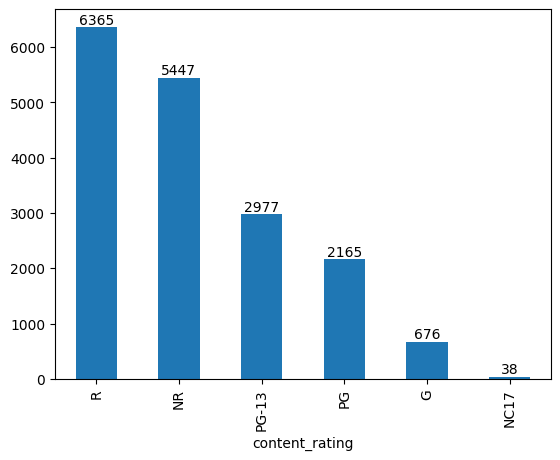

In [11]:
print(f'Content Rating category: {df_movie.content_rating.unique()}')

# Categories in content_rating feature
ax = df_movie.content_rating.value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])

In [12]:
#One Hot Encoding Content Rating Category
content_rating = pd.get_dummies(df_movie.content_rating)
content_rating.head()

,G,NC17,NR,PG,PG-13,R
0,False,False,False,True,False,False
1,False,False,False,False,False,True
2,False,False,False,False,False,True
3,False,False,True,False,False,False
4,True,False,False,False,False,False


We need to make sure to convert all categorical attributes to numerical attributes

Step 2: Convert audience_status attribute from categorical to numerical using Ordinal Encoding

Audience status category: ['Spilled' 'Upright' nan]


[Text(0, 0, '9385'), Text(0, 0, '7870')]

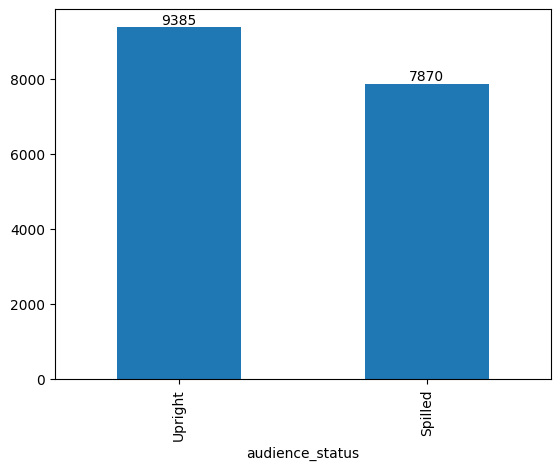

In [13]:
print(f'Audience status category: {df_movie.audience_status.unique()}')

# Categories in audience status
ax = df_movie.audience_status.value_counts().plot(kind='bar')
ax.bar_label(ax.containers[0])

In [14]:
# Ordinal Encoding
audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled','Upright'],[0,1]))
audience_status.head()

/tmp/ipykernel_26/1135982600.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  audience_status = pd.DataFrame(df_movie.audience_status.replace(['Spilled','Upright'],[0,1]))


,audience_status
0,0.0
1,1.0
2,0.0
3,1.0
4,1.0


Step 3: Converting Tomatometer_status column from categorical to numerical using Ordinal encoding

In [15]:
# Ordinal encoding on tomatometer_status
tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten','Fresh','Certified-Fresh'],[0,1,2]))
tomatometer_status

/tmp/ipykernel_26/978407632.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tomatometer_status = pd.DataFrame(df_movie.tomatometer_status.replace(['Rotten','Fresh','Certified-Fresh'],[0,1,2]))


,tomatometer_status
0,0
1,2
2,1
3,2
4,1
...,...
17707,0
17708,2
17709,1
17710,1


In [16]:
df_movie.columns

Index(['movie_title', 'movie_info', 'critics_consensus', 'content_rating',
       'genres', 'directors', 'authors', 'actors', 'original_release_date',
       'streaming_release_date', 'runtime', 'production_company',
       'tomatometer_status', 'tomatometer_rating', 'tomatometer_count',
       'audience_status', 'audience_rating', 'audience_count',
       'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count',
       'tomatometer_rotten_critics_count'],
      dtype='object')

In [17]:
theater_run= pd.to_datetime(df_movie.streaming_release_date)-pd.to_datetime(df_movie.original_release_date)
theater_run=theater_run.dt.days
theater_run.name = 'theater_run'

In [18]:
# Feature dataframe with relevant and encoded columns
df_feature = pd.concat([df_movie[['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']]
                        ,theater_run, content_rating, audience_status, tomatometer_status], axis=1).dropna()
df_feature.head()

,runtime,tomatometer_rating,tomatometer_count,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count,theater_run,G,NC17,NR,PG,PG-13,R,audience_status,tomatometer_status
0,119.0,49.0,149.0,53.0,254421.0,43,73,76,2112.0,False,False,False,True,False,False,0.0,0
1,90.0,87.0,142.0,64.0,11574.0,44,123,19,858.0,False,False,False,False,False,True,1.0,2
2,122.0,67.0,24.0,53.0,14684.0,2,16,8,12711.0,False,False,False,False,False,True,0.0,1
3,95.0,100.0,54.0,97.0,105386.0,6,54,0,21825.0,False,False,True,False,False,False,1.0,2
4,127.0,89.0,27.0,74.0,68918.0,5,24,3,22806.0,True,False,False,False,False,False,1.0,1


In [19]:
#Total data count
df_feature.count()

runtime                             15988
tomatometer_rating                  15988
tomatometer_count                   15988
audience_rating                     15988
audience_count                      15988
tomatometer_top_critics_count       15988
tomatometer_fresh_critics_count     15988
tomatometer_rotten_critics_count    15988
theater_run                         15988
G                                   15988
NC17                                15988
NR                                  15988
PG                                  15988
PG-13                               15988
R                                   15988
audience_status                     15988
tomatometer_status                  15988
dtype: int64

In [20]:
# Split the data into training and test data
X_train,X_test,y_train,y_test=train_test_split(df_feature.drop(['tomatometer_status'],axis=1),df_feature['tomatometer_status'],test_size=0.2,random_state=42,shuffle=True)
print(f'Training data size:{len(X_train)}, Testing data size:{len(X_test)}')

Training data size:12790, Testing data size:3198


Decision Tree

In [21]:
labels=df_feature['tomatometer_status'].unique()
labels

array([0, 2, 1])

In [22]:
tree=DecisionTreeClassifier(random_state=42)
tree.fit(X_train,y_train)
# Predict the test data with trained tree classifier
y_predict_tree = tree.predict(X_test)

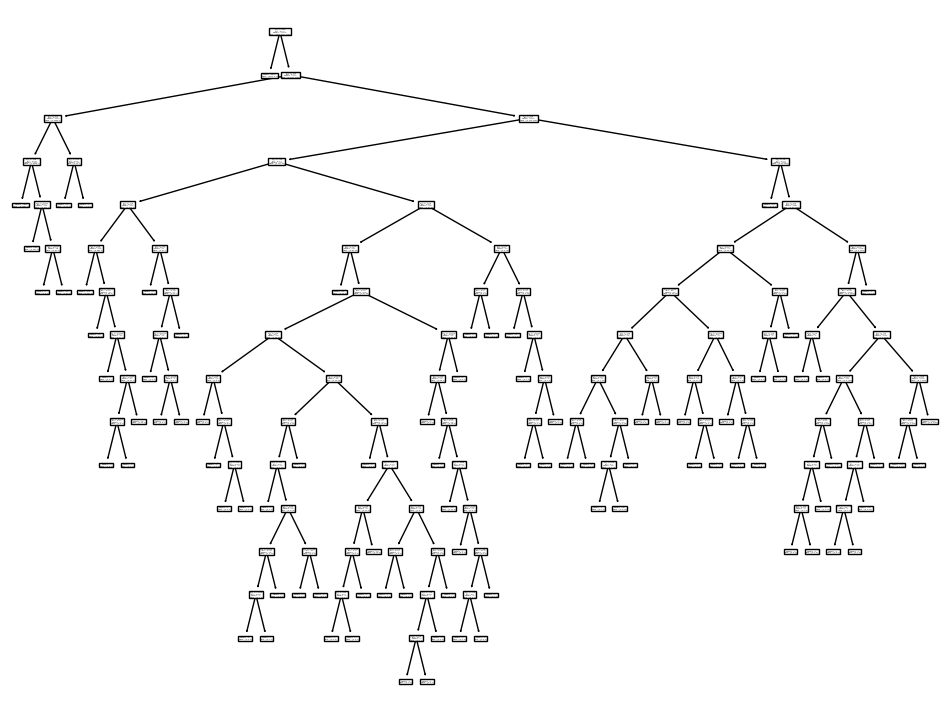

In [23]:
# Visualize decision logic of decision tree model
fig, ax = plt.subplots(figsize=(12,9))
plot_tree(tree, ax= ax)
plt.show()

In [24]:
print(f'Accuracy of model: {accuracy_score(y_test, y_predict_tree)}')
print(classification_report(y_test, y_predict_tree))
cm = confusion_matrix(y_test,y_predict_tree)

Accuracy of model: 0.9896810506566605
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1415
           1       0.98      0.99      0.99      1168
           2       0.98      0.97      0.97       615

    accuracy                           0.99      3198
   macro avg       0.99      0.99      0.99      3198
weighted avg       0.99      0.99      0.99      3198



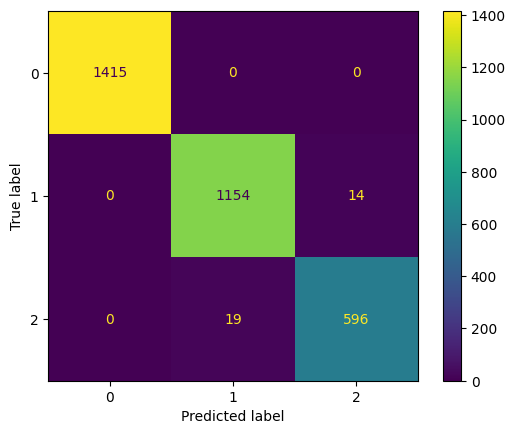

In [25]:
#Plotting Confusion Matrix
ConfusionMatrixDisplay(cm).plot()

Random Forest

In [26]:
rf = RandomForestClassifier(random_state=42)

# Train Random Forest Classifier on training data
rf.fit(X_train, y_train)

# Predict test data with trained model
y_predict_rf = rf.predict(X_test)

In [27]:
print(f'Accuracy of model: {accuracy_score(y_test, y_predict_rf)}')
print(classification_report(y_test, y_predict_rf))
cm = confusion_matrix(y_test,y_predict_rf)

Accuracy of model: 0.9912445278298937
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1415
           1       0.98      0.99      0.99      1168
           2       0.99      0.97      0.98       615

    accuracy                           0.99      3198
   macro avg       0.99      0.99      0.99      3198
weighted avg       0.99      0.99      0.99      3198



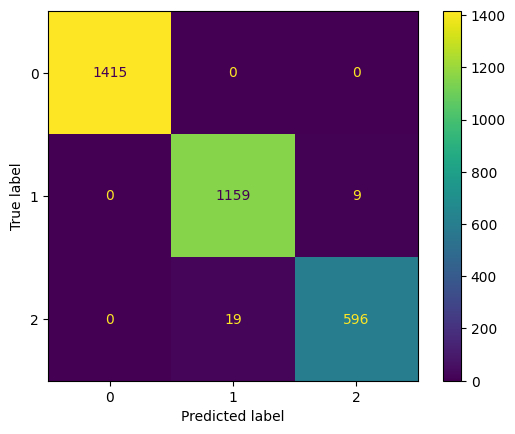

In [28]:
#Plotting Confusion Matrix
ConfusionMatrixDisplay(cm).plot()

runtime = 0.003308161291449329
tomatometer_rating = 0.5068241973750114
tomatometer_count = 0.09117044901366324
audience_rating = 0.042445116991288376
audience_count = 0.009100000849426
tomatometer_top_critics_count = 0.027927542451123073
tomatometer_fresh_critics_count = 0.16037900821013437
tomatometer_rotten_critics_count = 0.11498646033853856
theater_run = 0.007448051544224736
G = 0.00012994958996974222
NC17 = 6.810454477908373e-06
NR = 0.00535337712666866
PG = 0.0002950578248506765
PG-13 = 0.0011892276628785365
R = 0.0006099055004757288
audience_status = 0.028826683775819758


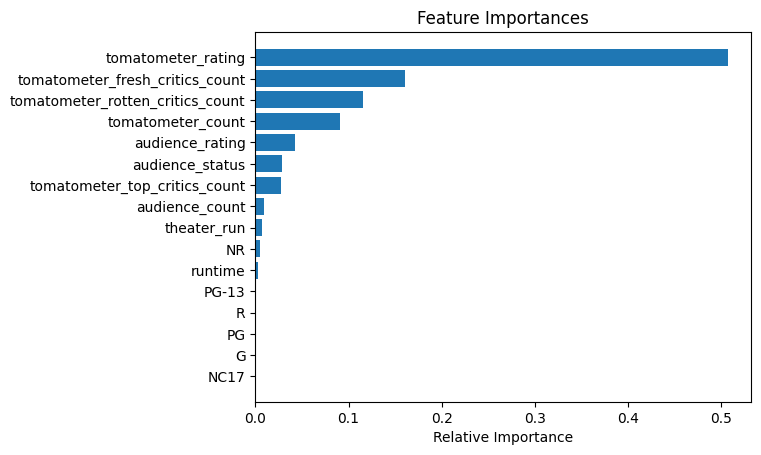

In [29]:
# Get the feature importance
feature_importance = rf.feature_importances_

# Print feature importance
for i, feature in enumerate(X_train.columns):
    print(f'{feature} = {feature_importance[i]}')

# Visualize feature from the most important to the least important
indices = np.argsort(feature_importance)
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importance[indices])
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Random Forest with Feature Selection

In [30]:
df_feature.columns

Index(['runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating',
       'audience_count', 'tomatometer_top_critics_count',
       'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count',
       'theater_run', 'G', 'NC17', 'NR', 'PG', 'PG-13', 'R', 'audience_status',
       'tomatometer_status'],
      dtype='object')

Dropping less important features and re-building random forest classifier

In [31]:
# Split data into train and test after feature selection
X_train, X_test, y_train, y_test = train_test_split(df_feature.drop(['tomatometer_status', 'NR', 'runtime', 'PG-13', 'R', 'PG','G', 'NC17'], axis=1),df_feature.tomatometer_status, test_size= 0.2, random_state=42)
print(f'Size of training data is {len(X_train)} and the size of test data is {len(X_test)}')

Size of training data is 12790 and the size of test data is 3198


In [32]:
# Initialize Random Forest class
rf = RandomForestClassifier(random_state=42)

# Train Random Forest on the training data after feature selection
rf.fit(X_train, y_train)

# Predict the traind model on the test data after feature selection
y_predict_rf_fsel = rf.predict(X_test)

In [33]:
# Print the accuracy score and the classification report
print(accuracy_score(y_test, y_predict_rf_fsel))
print(classification_report(y_test, y_predict_rf_fsel))

# Plot the confusion matrix
cm = confusion_matrix(y_test,y_predict_rf_fsel)

0.9903064415259537
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1415
           1       0.98      0.99      0.99      1168
           2       0.98      0.97      0.97       615

    accuracy                           0.99      3198
   macro avg       0.99      0.99      0.99      3198
weighted avg       0.99      0.99      0.99      3198



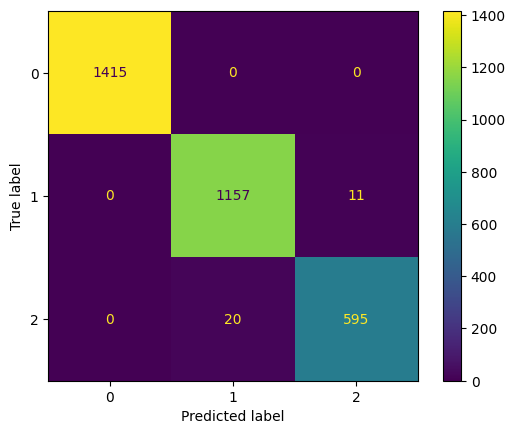

In [34]:
#Plotting Confusion Matrix
ConfusionMatrixDisplay(cm).plot()

Weighted RF with feature selection to handle unequal target class distribution

[Text(0, 0, '6985'), Text(0, 0, '5895'), Text(0, 0, '3108')]

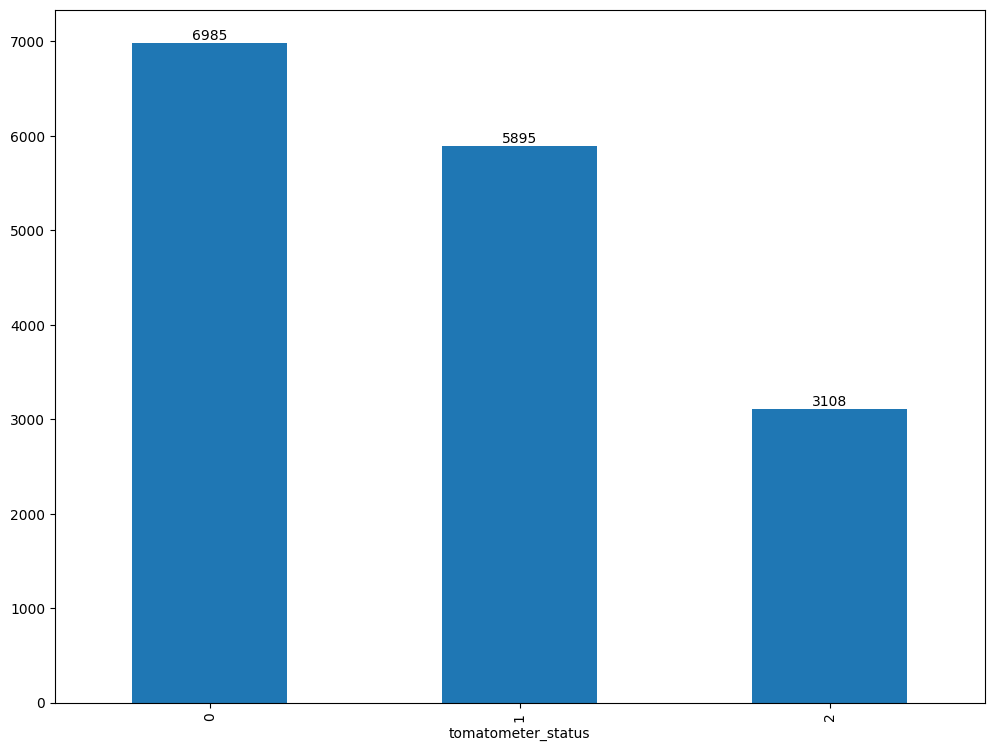

In [35]:
# Check class distribution of target variable once more
ax = df_feature.tomatometer_status.value_counts().plot(kind='bar', figsize=(12,9))
ax.bar_label(ax.containers[0])

In [36]:
# Compute class weight
class_weight = compute_class_weight(class_weight= 'balanced', classes= np.unique(df_feature.tomatometer_status),
                      y = df_feature.tomatometer_status.values)

class_weight_dict = dict(zip(range(len(class_weight.tolist())), class_weight.tolist()))
class_weight_dict

{0: 0.76296826533047, 1: 0.9040429742719819, 2: 1.7147147147147148}

In [37]:
# Initialize Random Forest model with weight information
rf_weighted = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)

# Train the model on the training data
rf_weighted.fit(X_train, y_train)

# Predict the test data with the trained model
y_predict = rf_weighted.predict(X_test)

In [38]:
#Print accuracy score and classification report
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

#Plot confusion matrix
# Plot the confusion matrix
cm = confusion_matrix(y_test,y_predict)

0.9903064415259537
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1415
           1       0.98      0.99      0.99      1168
           2       0.98      0.97      0.97       615

    accuracy                           0.99      3198
   macro avg       0.99      0.99      0.99      3198
weighted avg       0.99      0.99      0.99      3198



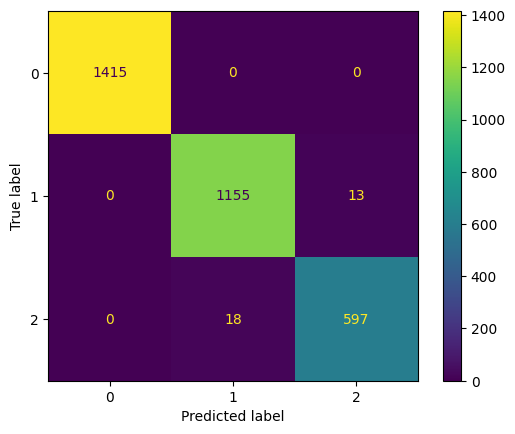

In [39]:
#Plotting Confusion Matrix
ConfusionMatrixDisplay(cm).plot()

Sentiment Analysis using Bert Model

In [40]:
# Read critics dataframe
path='/kaggle/input/rotten-tomatoes-movies-rating/datasets/rotten_tomatoes_critic_reviews_50k.csv'
df_critics = pd.read_csv(path)
df_critics.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [41]:
df_critics=df_critics.drop('rotten_tomatoes_link',axis=1)
df_critics

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...
...,...,...,...,...,...,...,...
49995,Chris Hewitt,False,St. Paul Pioneer Press,Rotten,NaN,2002-02-07,The smarter an Arnold Schwarzenegger movie tri...
49996,Nick Carter,False,Milwaukee Journal Sentinel,Rotten,NaN,2002-02-07,A relative letdown.
49997,Gary Dowell,True,Dallas Morning News,Rotten,NaN,2002-02-07,The movie straddles the fence between escapism...
49998,Walter Chaw,False,Film Freak Central,Rotten,0/4,2002-02-07,Enough similarities to Gymkata and Howie Long'...


In [42]:
df_critics.dropna(subset=['review_content'],inplace=True)

In [43]:
df_critics.isna()

,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,False,False,False,False,True,False,False
1,False,False,False,False,True,False,False
2,True,False,False,False,True,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...
49995,False,False,False,False,True,False,False
49996,False,False,False,False,True,False,False
49997,False,False,False,False,True,False,False
49998,False,False,False,False,False,False,False


In [44]:
df_critics['label'] = df_critics['review_type'].map({'Fresh': 1, 'Rotten': 0})  # Convert 'review_type' into numerical labels

In [45]:

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode sequences in the dataset
def encode_reviews(reviews,max_length=128):
    input_ids = []
    attention_masks = []
    for review in reviews:
        encoded = tokenizer.encode_plus(
            text=review,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

input_ids, attention_masks = encode_reviews(df_critics['review_content'])
labels = torch.tensor(df_critics['label'].values)



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [46]:
# Split the dataset into training and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

# Create the DataLoader
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Load BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

# Set up optimizer and schedule
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define accuracy metric
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch_i in range(0, epochs):
    # Training
    model.train()
    total_loss = 0
    for step, batch in enumerate(train_dataloader):
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Average training loss: {avg_train_loss}")

    # Validation
    model.eval()
    eval_accuracy = 0
    eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        eval_steps += 1
    print(f"Validation Accuracy: {eval_accuracy/eval_steps}")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Average training loss: 0.36795548929787075
Validation Accuracy: 0.8589308785529716
Average training loss: 0.22938398419492867
Validation Accuracy: 0.8736272609819122


In [47]:
def predict_sentiment(model, reviews):
    """
    Predicts the sentiment of one or more reviews using the fine-tuned BERT model.

    Parameters:
    model (BertForSequenceClassification): The fine-tuned BERT model.
    reviews (list of str): A list containing the review(s) to be classified.

    Returns:
    list of str: A list containing the sentiment predictions ('Fresh' or 'Rotten') for each review.
    """
    model.eval()  # Put the model in evaluation mode

    predictions = []

    for review in reviews:
        # Tokenize and encode the review like we did before
        encoded_review = tokenizer.encode_plus(
            review,
            max_length=128,
            add_special_tokens=True,
            return_attention_mask=True,
            pad_to_max_length=True,
            return_tensors='pt',
        )

        input_ids = encoded_review['input_ids'].to(device)
        attention_mask = encoded_review['attention_mask'].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)

        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()

        # Determine the class with the highest probability
        prediction = np.argmax(logits, axis=1).flatten()

        # Convert prediction to 'Fresh' or 'Rotten'
        predictions.append('Fresh' if prediction == 1 else 'Rotten')

    return predictions

# Example usage
reviews = [
    "This movie was excellent! The performances were oscar-worthy.",
    "Movie seems pretty long to me",
]

predictions = predict_sentiment(model, reviews)
for review, prediction in zip(reviews, predictions):
    print(f"Review: {review}\nPredicted Sentiment: {prediction}\n")


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Review: This movie was excellent! The performances were oscar-worthy.
Predicted Sentiment: Fresh

Review: Movie seems pretty long to me
Predicted Sentiment: Rotten



/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2619: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
